In [54]:
import pden
import pden.Net
import pden.Operations
import pden.PDENet

import tensorflow as tf

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from IPython.display import clear_output

%load_ext autoreload
%autoreload 1

%aimport pden.Net
%aimport pden.Operations
%aimport pden.PDENet

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
def der(y, x, y_shape: int, x_shape: int):
    ys = tf.split(y, [1] * y_shape, 1)
    def _der(i, j=[]):
        f = ys[i]
        for _j in j:
            fs = tf.gradients(f, x)[0]
            f  = tf.split(fs, [1] * x_shape, 1)[_j]        
        return f
    return _der

In [56]:
k = 16

net_1 = pden.Net.BasicNet(
    pden.Operations.Linear(feature_out=k, feature_in=1, random_init = True),
    pden.Operations.ActivationFunction(tf.nn.tanh),
    pden.Operations.Linear(feature_out=k, feature_in=k, random_init = True),
    pden.Operations.ActivationFunction(tf.cos)
)

net_2 = pden.Net.BasicNet(
    pden.Operations.Linear(feature_out=k, feature_in=1, random_init = True),
    pden.Operations.ActivationFunction(tf.nn.tanh),
    pden.Operations.Linear(feature_out=k, feature_in=k, random_init = True),
    pden.Operations.ActivationFunction(tf.cos)
)

net_3 = pden.Net.BasicNet(
    pden.Operations.Linear(feature_out=1, feature_in=k, random_init = True)
)

pnet = pden.PDENet.HadamardNET(dimension_in=2, nets=[net_1, net_2, net_3], hidden=k)

print(net_1)
print(net_2)
print(net_3)

Net 4:
	24	Linear: [1 -> 16]
	19	Activation funciton: <function tanh at 0x10a4423b0>
	5	Linear: [16 -> 16]
	22	Activation funciton: <function cos at 0x10a3fe0e0>
Net 29:
	24	Linear: [1 -> 16]
	13	Activation funciton: <function tanh at 0x10a4423b0>
	32	Linear: [16 -> 16]
	15	Activation funciton: <function cos at 0x10a3fe0e0>
Net 2:
	25	Linear: [16 -> 1]


In [57]:
x = tf.placeholder(tf.float64, [None, 2])
y = pnet.forward(x)

x0 = tf.placeholder(tf.float64, [None, 2])
yx0 = pnet.forward(x0)

t0 = tf.placeholder(tf.float64, [None, 2])
yt0 = pnet.forward(t0)

t1 = tf.placeholder(tf.float64, [None, 2])
yt1 = pnet.forward(t1)

der_gen = der(y, x, 1, 2)
dy_dx = der_gen(0, j=[0])
dy_dt = der_gen(0, j=[1])
d2y_dx2 = der_gen(0, j=[0, 0])
d2y_dt2 = der_gen(0, j=[1, 1])

In [58]:
_x, _t = tf.split(x, [1, 1], 1)
_x0, _ = tf.split(t0, [1, 1], 1)

In [59]:
pnet = pnet.add_loss(tf.reduce_mean(tf.pow(dy_dx + dy_dt + _x + _t - 1, 2)))
pnet = pnet.add_loss(tf.reduce_mean(tf.pow(yx0, 2)), weight=1.0)
pnet = pnet.add_loss(tf.reduce_mean(tf.pow(yt1, 2)), weight=1.0)
pnet = pnet.add_loss(tf.reduce_mean(tf.pow(yt0 - _x0, 2)), weight=1.0)

In [68]:
learning_rate = 1e-2
training_epochs = 2000
display_step = 500

opt = tf.train.AdamOptimizer(learning_rate = learning_rate)
train = opt.minimize(pnet.loss)

init = tf.global_variables_initializer()

In [69]:
losses = []

In [70]:
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
    
#     P = np.random.uniform(0, 0.5, size=(1,))
    
    X = np.random.rand(100, 2)
    X0= np.random.rand(25, 2)
    X0[:, 0] = 0
    T1= np.random.rand(25, 2)
    T1[:, 1] = 1
    T0= np.random.rand(25, 2)
    T0[:, 1] = 0
    
    _, l, Y = sess.run([train, pnet.loss, y], feed_dict={
        x: X,
        x0: X0,
        t0: T0, 
        t1: T1
    })
    
    losses.append(np.log(l))
    
    if epoch % display_step == 0 and True:
        print(f'Training error for net is "{l}". Epoch {epoch}')
#         X = np.linspace(0, 1, 100)
#         T = np.linspace(0, 1, 100)
#         X, T = np.meshgrid(X, T)

#         clear_output(wait=True)
        
#         plt.plot(X.flatten(), Y.flatten(), '--r', label='Net')
#         plt.plot(X.flatten(), X.flatten() ** 2, '--b', label='Analytical')
#         plt.legend()
#         plt.show()

        
print("Optimization Finished!")

Training error for net is "29.960095122524947". Epoch 0
Training error for net is "0.003051649129138182". Epoch 500
Training error for net is "0.0009549813450889556". Epoch 1000
Training error for net is "0.0006688005140028245". Epoch 1500
Optimization Finished!


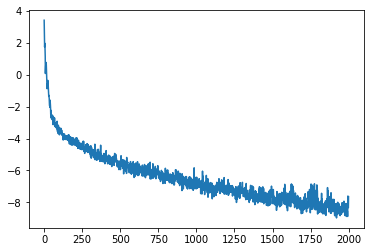

In [71]:
plt.plot(losses)